In [ ]:
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Model and performance
#!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
X, y = make_classification(n_samples=100000, n_features=32, n_informative=32,
n_redundant=0, n_repeated=0, n_classes=2,
n_clusters_per_class=1,
weights=[0.995, 0.005],
class_sep=0.5, random_state=0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the minority classes")

The number of records in the training dataset is 80000
The number of records in the test dataset is 20000
The training dataset has 79200 records for the minority classes


In [ ]:
# Keep only the normal data for the training dataset
X_train_normal = X_train[np.where(y_train == 0)]
# Input layer
input = tf.keras.layers.Input(shape=(32,))
# Encoder layers
encoder =tf.keras.Sequential([

layers.Dense(16, activation='relu'),
layers.Dense(8, activation='relu'),
layers.Dense(4, activation='relu')])(input)
# Decoder layers
decoder = tf.keras.Sequential([
layers.Dense(8, activation="relu"),
layers.Dense(16, activation="relu"),
layers.Dense(32, activation="sigmoid")])(encoder)
# Create the autoencoder
autoencoder = tf.keras.Model(inputs=input, outputs=decoder)

In [ ]:
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mae')
# Fit the autoencoder
history = autoencoder.fit(X_train_normal, X_train_normal,
epochs=20,
batch_size=64,
validation_data=(X_test, X_test),
shuffle=True)


Epoch 1/20
1238/1238 [==============================] - 5s 3ms/step - loss: 2.5349 - val_loss: 2.5081
Epoch 2/20
1238/1238 [==============================] - 3s 3ms/step - loss: 2.4967 - val_loss: 2.4917
Epoch 3/20
1238/1238 [==============================] - 4s 3ms/step - loss: 2.4822 - val_loss: 2.4812
Epoch 4/20
1238/1238 [==============================] - 4s 3ms/step - loss: 2.4752 - val_loss: 2.4774
Epoch 5/20
1238/1238 [==============================] - 5s 4ms/step - loss: 2.4716 - val_loss: 2.4738
Epoch 6/20
1238/1238 [==============================] - 4s 3ms/step - loss: 2.4691 - val_loss: 2.4729
Epoch 7/20
1238/1238 [==============================] - 3s 3ms/step - loss: 2.4677 - val_loss: 2.4709
Epoch 8/20
1238/1238 [==============================] - 3s 3ms/step - loss: 2.4663 - val_loss: 2.4695
Epoch 9/20
1238/1238 [==============================] - 3s 3ms/step - loss: 2.4627 - val_loss: 2.4663
Epoch 10/20
1238/1238 [==============================] - 4s 3ms/step - loss: 2.461

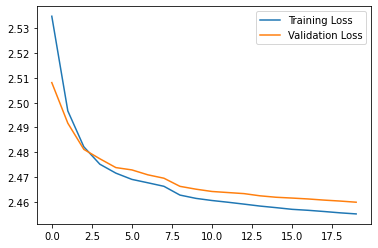

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"] , label="Validation Loss")
plt.legend();

In [ ]:
# Predict anomalies/outliers in the training dataset
prediction = autoencoder.predict(X_test)


625/625 [==============================] - 1s 1ms/step


In [ ]:
# Get the mean absolute error between actual and reconstruction/prediction
prediction_loss = tf.keras.losses.mae(prediction, X_test)

In [ ]:
# Check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)
print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')


The prediction loss threshold for 2% of outliers is 3.45


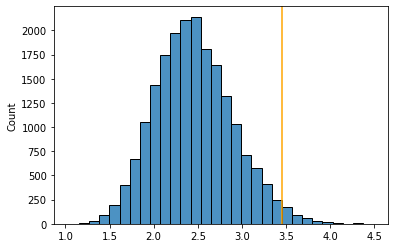

In [ ]:
# Visualize the threshold
sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')


In [ ]:
# Check the model performance at 2% threshold
threshold_prediction = [0 if i < loss_threshold else 1 for i in prediction_loss]
# Check the prediction performance
print(classification_report(y_test, threshold_prediction))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19803
           1       0.01      0.01      0.01       197

    accuracy                           0.97     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.98      0.97      0.98     20000

